In [1]:
import pandas as pd
import numpy as np
import re
import math

import requests, json
import pandas as pd

NOTION_TOKEN = "secret_AIc5tovrF5rnoYWC54z9CzwQUNb5d2A1q3HPKwOEqup"
DATABASE_ID = "213b4ff8bb884cfc987139ae53aa4396"

headers = {
    "Authorization": "Bearer " + NOTION_TOKEN,
    "Content-Type": "application/json",
    "Notion-Version": "2022-06-28",
}

DATABASE_ID_LIST = ["db2b026a03f0442f828bc88dcdbf143c", "c238334399d54b10aad0bcb84cb77d5c", "bf7efa466c624f1ca200d05c5cf34f58", "2f0e230f82974dd09841ae871cb558f9", "b708c8576ea34bb385d24aedc5b1277b", "d6211c2113914ecc86332d4bb305a115", "a8b0289c72eb4daaa1063152eb5e787a", "73e5dc61f97f4f2095c0265f2dae70d8", "1a91276509b246dda4c170a248d096c2", "6a374753947e42f7aa57fac3a474b78f"]
YEAR_LIST = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

def readDatabase(DATABASE_ID_LIST, YEAR_LIST, headers):
    for id in zip(DATABASE_ID_LIST, YEAR_LIST):
        readUrl = f"https://api.notion.com/v1/databases/{id[0]}/query"
        res = requests.request("POST", readUrl, headers=headers)
        data = res.json()
        print(res.status_code)

        if res.status_code == 200:
            try:
                with open(f"./{id[1]}.json", 'w', encoding='utf8') as f:
                    json.dump(data, f, ensure_ascii=False)
            except:
                continue
            
readDatabase(DATABASE_ID_LIST, YEAR_LIST, headers)

def jsonToDataFrame(YEAR_LIST):
    temp = {}
    year_list = []
    name = []
    birth = []
    registered = []
    fullTime = []
    responsibilities = []
    career = []
    stock = []
    time1 = []
    time2 = []
    position = []

    for year in YEAR_LIST:
        with open(f"./{year}.json", 'r') as f:
            json_data = json.load(f)
            for i in range(len(json_data['results'])):
                properties = json_data['results'][i]['properties']
                year_list.append(year)
                for key in properties:
                    if key == '이름':
                        name.append(properties[key]['title'][0]['text']['content'])
                    elif key == '출생년월':
                        birth.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '등기임원 여부':
                        registered.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '상근 여부':
                        fullTime.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '담당업무':
                        responsibilities.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '주요경력':
                        career.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '의결권 있는 주식수':
                        stock.append(properties[key]['number'])
                    elif key == '재직기간':
                        time1.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '임기만료일':
                        time2.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '직위':
                        position.append(properties[key]['rich_text'][0]['text']['content'])

    temp['이름'] = name
    temp['연도'] = year_list
    temp['출생년월'] = birth
    temp['등기임원 여부'] = registered
    temp['상근 여부'] = fullTime
    temp['담당업무'] = responsibilities
    temp['주요경력'] = career
    temp['의결권 있는 주식수'] = stock
    temp['재직기간'] = time1
    temp['임기만료일'] = time2
    temp['직위'] = position
    return temp

dict = jsonToDataFrame(YEAR_LIST)

df = pd.DataFrame.from_dict(data=dict, orient='columns')

401
401
401
401
401
401
401
401
401
401


In [3]:
df['의결권 있는 주식수'].fillna(0.0, inplace=True)
#'\xa0' 처리
df['주요경력']=df['주요경력'].str.replace('\xa0', '')
#대학, 전공 피처 생성
temp=df['주요경력'].str.split('\n')
colleges=temp.str.get(0)

#추가로 처리해줘야될 대학 form 맞춰주기
colleges[colleges== 'University of Bath 사회과학대학원(석사)'] ='UniversityofBath 사회과학대학원(석사)'
colleges[colleges== 'Florida International University 경영대학원(박사)']='FloridaInternationalUniversity 경영대학원(박사)'
colleges[colleges== 'Ohio State University 정책대학원(박사)'] = 'OhioStateUniversity 정책대학원(박사)'
colleges[colleges== 'KDI국제정책대학원(석사)'] = 'KDI 국제정책대학원(석사)'
colleges[colleges== '상명여자사범대'] = '상명여자사범대 교육학'
colleges[colleges== '한국외국어대경영학(석사)'] = '한국외국어대 경영학(석사)'
colleges[colleges== '미시간대학교 경영대학원 MBA'] = '미시간대학교 경영대학원MBA'

#대학, 전공으로 나누기
ttemp = colleges.str.split() 

#대학 피처 생성
df['대학교']=ttemp.str.get(0)

#전공 피처 생성
tttemp = ttemp.str.get(1)
tttemp=tttemp.replace(r'\([^)]*\)', '', regex=True)
df['전공']=tttemp

#근속연수 생성
def create_work_years(x):
  temp = re.split(r'~|~\n', x)
  temp[0] = temp[0].strip()
  temp[1] = temp[1].strip()
  return int(temp[1][:4]) - int(temp[0][:4])

df['근속연수'] = df['재직기간'].apply(lambda x : create_work_years(x))

#주요경력 전처리
def replace_career(x):
  temp = [string.split() for string in re.split(r'\n |\n', x)]
  if len(temp)==1 :
    return {'대신증권'}
  else:
    return set(list(zip(*temp[1:]))[0])

df['주요경력요약'] = df['주요경력'].apply(lambda x : replace_career(x))

In [19]:
df_2023 = df[df['연도']==2023].reset_index(drop=True)
df_2023.head(5)

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위,대학교,전공,근속연수,주요경력요약
0,김봉진,2023,1969.07,미등기,상근,동부WM부문장,동아대 경영학(박사)\n대신증권 사하지점장\n대신증권 부산센터 이사대우센터장\n대신...,73.0,2021.11.22~2023.03.31,2024.03.31,상무,동아대,경영학,2,{대신증권}
1,김성호,2023,1950.03,사외이사,비상근,감사위원,건국대 법학(박사)\n국가청렴위원회 사무처장\n제58대 법무부장관\n現)재단법인 행...,0.0,2022.03.18~2023.03.31,2024.03.31,사외이사,건국대,법학,1,"{現)재단법인, 국가청렴위원회, 제58대}"
2,양홍석,2023,1981.04,사내이사,상근,-,서울대 경영학\n대신투자신탁운용 상무이사\n대신증권 전무\n대신증권 부사장\n대신증...,5175034.0,2007.10.01~2023.03.31,2024.03.31,부회장,서울대,경영학,16,"{대신증권, 대신투자신탁운용}"
3,강준규,2023,1972.02,미등기,상근,디지털부문장,가천대학교 무역학\n대신증권 수지지점장\n대신증권 여의도영업부장\n재경1WM부문장,5351.0,2020.11.23~2023.03.31,2024.03.31,상무,가천대학교,무역학,3,"{대신증권, 재경1WM부문장}"
4,최근영,2023,1963.12,미등기,상근,준법감시인 준법지원부문장,조선대 회계학\n대신자산운용 법무본부장\n대신자산운용 리스크관리본부장/준법감시인\n...,13449.0,2020.01.21~2023.03.31,2023.12.31,상무,조선대,회계학,3,"{대신증권, 대신자산운용, 대신저축은행, 대신에이엠씨}"


c:\Users\morat\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\morat\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


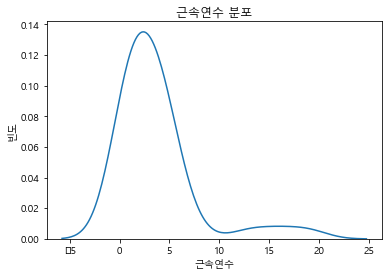

평균 근속연수:  3.625


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seaborn 히스토그램 그리기
sns.kdeplot(x=df_2023['근속연수'])
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.xlabel('근속연수')
plt.ylabel('빈도')
plt.title('근속연수 분포')
plt.show()
print('평균 근속연수: ', df_2023['근속연수'].mean())

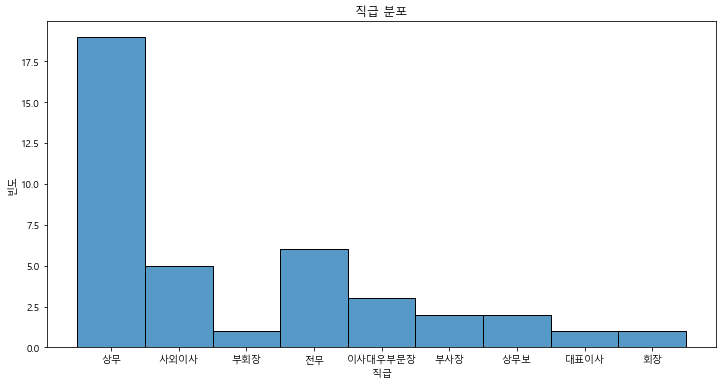

In [21]:
plt.figure(figsize=(12, 6))

sns.histplot(df_2023['직위'])

plt.xlabel('직급')
plt.ylabel('빈도')
plt.title('직급 분포')
plt.show()

In [23]:
college_dict = {'서울경기':['상명여자사범대', '서울대', '홍익대', '성균관대', '연세대', '연세대학교', '동국대', '중앙대', '한국외대', '한국외국어대', '세종대학교', '세종대', '성균관대학교', '경희대', '서강대', '고려대', '건국대', '가천대', '가천대학교', '한양대', '명지대'],
                   '광역시':['부경대', '경북대', '전남대', '조선대', '한국과학기술원', '가천대', '인하대', '동아대', '대전대', '울산대', '영남공업전문대'],
                   '그외한국':['전북대', '원광대', '충북대', '충북대학교', '강원대', 'KDI'],
                   '해외':['FloridaInternationalUniversity', 'OhioStateUniversity', 'UniversityofBath', '조지아공대', 'Brown대', '카네기멜론대', '미시간대학교']}



ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().